In [1]:
import pandas as pd # Import pandas library for data handling

In [4]:
data = pd.read_csv(r"C:\Users\reina\Desktop\Research\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\ptbxl_database.csv") # Load the CSV file into a pandas DataFrame

In [12]:
data.shape # Check the shape of the dataset (rows, columns)

(21837, 28)

In [13]:
data.head() # Show first 5 rows of the dataset to inspect values

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [14]:
data.columns # List all column names to see available features

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [8]:
df = data[["patient_id", "age", "sex", "scp_codes", "heart_axis", "nurse"]] # Select only relevant columns for our ML project
df.head() # Confirm selection worked correctly

,patient_id,age,sex,scp_codes,heart_axis,nurse
0,15709.0,56.0,1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,2.0
1,13243.0,19.0,0,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,2.0
2,20372.0,37.0,1,"{'NORM': 100.0, 'SR': 0.0}",NaN,2.0
3,17014.0,24.0,0,"{'NORM': 100.0, 'SR': 0.0}",NaN,2.0
4,17448.0,19.0,1,"{'NORM': 100.0, 'SR': 0.0}",NaN,2.0


In [10]:
import ast # Import ast module to convert string representations of dictionaries into actual dicts
df = df.copy()  # avoid the warning
df["scp_codes"] = df["scp_codes"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) #convert string dicts to actual dictionaries
df["main_diag"] = df["scp_codes"].apply(lambda d: max(d, key=d.get) if isinstance(d, dict) else None) #extract the key with the highest value as main diagnosis

In [15]:
import numpy as np  # For generating random numbers

In [17]:
# Step 1: Create synthetic blood-test features
# We'll generate some common biomarkers used in heart-attack prediction
np.random.seed(42) # np.random is NumPy’s random number module; seed(42) sets a starting point so random numbers are the same every run (reproducibility)

In [26]:
#we’re giving the model realistic-looking blood-test data to train on alongside ECG data.
# np.random.normal() generates random numbers from a normal distribution
# loc = mean value (center)
# scale = standard deviation (spread)
# size = number of rows in df (one unique value per patient)
# Create troponin values (ng/mL), normal ~0-0.04
df['troponin'] = np.random.normal(loc=0.03, scale=0.01, size=len(df))

In [20]:
# Create creatinine values (mg/dL), normal ~0.6-1.3
df['creatinine'] = np.random.normal(loc=1.0, scale=0.2, size=len(df))

In [21]:
# Create glucose levels (mg/dL), normal fasting ~70-100
df['glucose'] = np.random.normal(loc=90, scale=10, size=len(df))

In [22]:
# Cholesterol (mg/dL), normal ~150-200
df['cholesterol'] = np.random.normal(loc=180, scale=30, size=len(df))

In [23]:
# LDL (mg/dL), normal ~100, bad if >160
df['LDL'] = np.random.normal(loc=100, scale=25, size=len(df))

In [24]:
# HDL (mg/dL), normal ~40-60, low is bad
df['HDL'] = np.random.normal(loc=50, scale=10, size=len(df))

In [25]:
# CK-MB (U/L), normal ~0-10, rises with heart muscle injury
df['CK_MB'] = np.random.normal(loc=5, scale=2, size=len(df))

In [27]:
# Step 2: Create synthetic target variable (AMI risk) for modeling
# We'll mark high risk (1) if any biomarker exceeds a threshold
df['AMI_label'] = (
    (df['troponin'] > 0.04) |
    (df['creatinine'] > 1.2) |
    (df['glucose'] > 120) |
    (df['cholesterol'] > 240) |
    (df['LDL'] > 130) |
    (df['HDL'] < 40) |   # low HDL is bad
    (df['CK_MB'] > 8)
).astype(int)

In [28]:
# Step 3: Select features (all blood-test biomarkers) for the model
features = ['troponin', 'creatinine', 'glucose', 'cholesterol', 'LDL', 'HDL', 'CK_MB']
X = df[features]  # predictor variables
y = df['AMI_label']  # target variable (high vs low AMI risk)

In [30]:
# Step 4: Split dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 #randomness for splitting the dataset(42 is conventionalbut it’s not required and doesn't have to be the same as seed)
)  # 80% train, 20% test

In [32]:
# Step 5: Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier # Import the Random Forest model from scikit-learn
#A Random Forest is an ensemble machine learning model.
#Ensemble means it combines many simpler models (in this case, decision trees) to make a stronger prediction.
model = RandomForestClassifier(n_estimators=100, random_state=42)# Create the Random Forest object with parameters. Build 100 decision trees in the forest.Fix random seed for reproducibility
model.fit(X_train, y_train)  # train the model on training data
# X_train = input features (biomarkers: troponin, creatinine, etc.)
# y_train = target labels (AMI risk: 0 = low risk, 1 = high risk)
# Random Forest internally:
#   - Builds 100 decision trees using random subsets of features and samples
#   - Each tree “votes” on the class for a patient
#   - Combining trees reduces overfitting and improves prediction accuracy
#overfitting: Performs extremely well on training data
#             Performs poorly on new, unseen data


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
# Step 6: Evaluate the model
# Check how well the model learned patterns from training data and how it performs on unseen test data
train_acc = model.score(X_train, y_train)  # Accuracy on training set
test_acc = model.score(X_test, y_test)     # Accuracy on testing set
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 1.0
Test Accuracy: 0.9990842490842491


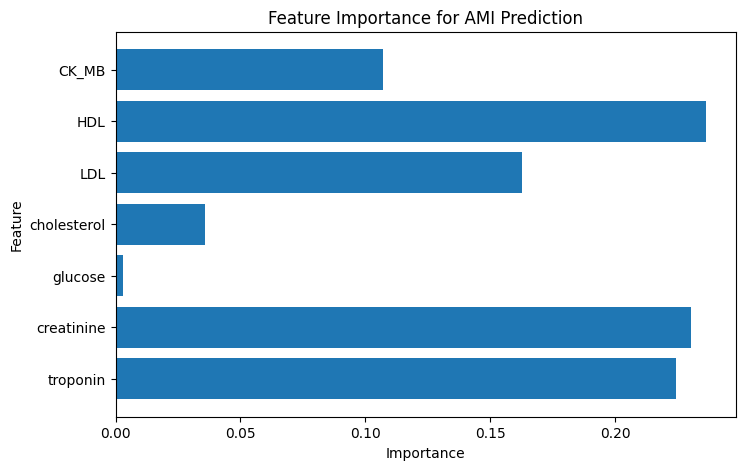

In [34]:
# Step 7: Feature importance
# Random Forest can tell us which biomarkers are most important for predicting AMI
import matplotlib.pyplot as plt
feature_importances = model.feature_importances_  # Get importance score for each feature
plt.figure(figsize=(8,5))
plt.barh(features, feature_importances)  # Horizontal bar plot
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for AMI Prediction")
plt.show()

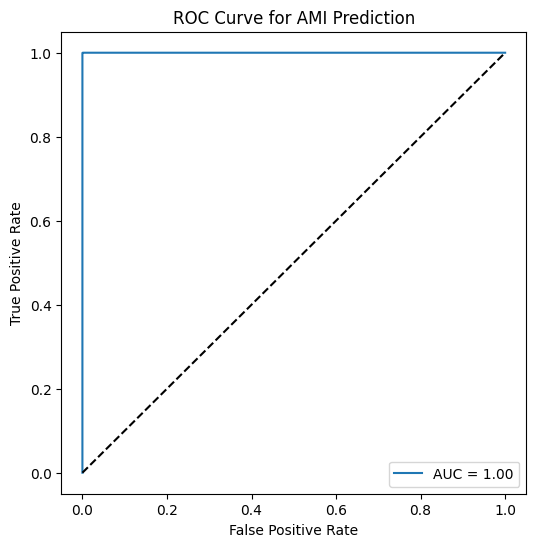

In [35]:
# Step 8: ROC Curve (how well model separates classes)
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = model.predict_proba(X_test)[:,1]  # Probability of class 1 (high risk)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # False Positive Rate, True Positive Rate
auc = roc_auc_score(y_test, y_pred_proba)  # Area under the curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], "k--")  # diagonal line for random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AMI Prediction")
plt.legend()
plt.show()

In [36]:
# Step 9: Save the trained model for future use
import joblib
joblib.dump(model, "ami_model.pkl")  # Save the trained Random Forest to a file
#Next time, you can load this model with:
#import joblib
#model = joblib.load("ami_model.pkl")  # loads the trained model back into Python
#No need to retrain — it’s ready to make predictions immediately.

['ami_model.pkl']

In [37]:
# Step 10: Make predictions with the saved model
# Load the trained model
model = joblib.load("ami_model.pkl")  # loads the trained Random Forest

In [38]:
# Create a sample patient with biomarker values
sample_patient = pd.DataFrame({
    'troponin': [0.05],      # example high troponin → risky
    'creatinine': [1.0],     # normal
    'glucose': [95],         # normal
    'cholesterol': [190],    # normal
    'LDL': [120],            # normal
    'HDL': [45],             # normal
    'CK_MB': [6]             # slightly elevated
})

In [39]:
# Make a prediction
prediction = model.predict(sample_patient)  # returns 0 or 1
risk = "HIGH RISK" if prediction[0] == 1 else "LOW RISK"
print("Predicted AMI risk for sample patient:", risk)

Predicted AMI risk for sample patient: HIGH RISK


In [40]:
# Predict probabilities
prob = model.predict_proba(sample_patient)  # returns probability for each class [low, high]
print("Probability of LOW/HIGH risk:", prob)

Probability of LOW/HIGH risk: [[0. 1.]]


In [50]:
# Create a DataFrame of multiple patients with mixed risk
sample_patients = pd.DataFrame({
    'troponin': [0.03, 0.02, 0.06],      # patient 1 normal, patient 2 normal, patient 3 high
    'creatinine': [1.0, 1.1, 0.9],       # all normal
    'glucose': [95, 100, 100],           # all normal
    'cholesterol': [190, 200, 200],      # all normal
    'LDL': [120, 120, 110],              # all normal
    'HDL': [45, 50, 50],                 # all normal
    'CK_MB': [6, 7, 4]                   # all normal except patient 3 slightly higher but below threshold
})

In [51]:
#Predict AMI risk for all patients in the DataFrame using the trained Random Forest model
predictions = model.predict(sample_patients)  # 0 = low risk, 1 = high risk

In [52]:
# Convert numeric predictions into human-readable labels
risks = ["HIGH RISK" if p == 1 else "LOW RISK" for p in predictions]

In [53]:
# Display results for each patient
#for loop prints each patient’s number and their predicted risk
for i, risk in enumerate(risks, 1):
    print(f"Patient {i}: {risk}")

Patient 1: LOW RISK
Patient 2: LOW RISK
Patient 3: HIGH RISK


,troponin,creatinine,glucose,cholesterol,LDL,HDL,CK_MB,Predicted_Risk,Risky_Biomarkers,Num_Risky_Biomarkers
0,0.030000,1.000000,95,190,120,45,6,LOW RISK,,0
1,0.020000,1.100000,100,200,120,50,7,LOW RISK,,0
2,0.060000,0.900000,100,200,110,50,4,HIGH RISK,troponin,1


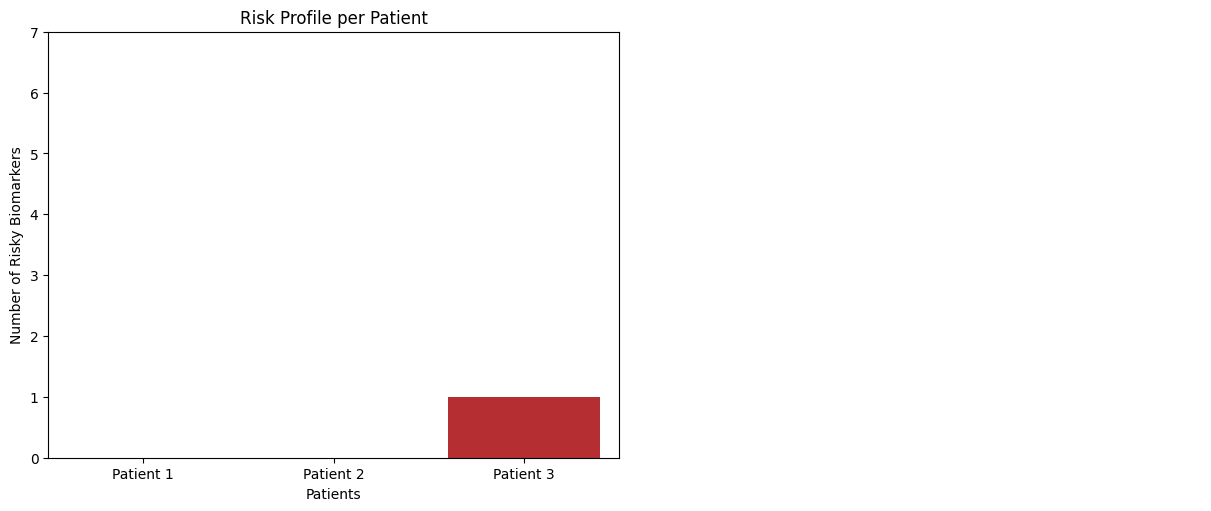

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from matplotlib.gridspec import GridSpec

# Keep only training features for prediction
X_sample = sample_patients[features]

# Predict risk using the trained model
predictions = model.predict(X_sample)
sample_patients['Predicted_Risk'] = ["HIGH RISK" if p==1 else "LOW RISK" for p in predictions]

# Identify risky biomarkers per patient
def find_risky_biomarkers(row):
    risky = []
    thresholds = {'troponin':0.04, 'creatinine':1.2, 'glucose':120,
                  'cholesterol':240, 'LDL':130, 'HDL':40, 'CK_MB':8}
    for col in thresholds:
        if col == 'HDL':
            if row[col] < thresholds[col]:
                risky.append(col)
        else:
            if row[col] > thresholds[col]:
                risky.append(col)
    return ", ".join(risky)

sample_patients['Risky_Biomarkers'] = sample_patients.apply(find_risky_biomarkers, axis=1)
sample_patients['Num_Risky_Biomarkers'] = sample_patients['Risky_Biomarkers'].apply(
    lambda x: len(x.split(', ')) if x else 0
)

# Highlight risky values in red using Styler.map
styled_table = sample_patients.style.map(lambda v: 'color: red' if v > 0.04 else '', subset=['troponin'])\
                                   .map(lambda v: 'color: red' if v > 1.2 else '', subset=['creatinine'])\
                                   .map(lambda v: 'color: red' if v > 120 else '', subset=['glucose'])\
                                   .map(lambda v: 'color: red' if v > 240 else '', subset=['cholesterol'])\
                                   .map(lambda v: 'color: red' if v > 130 else '', subset=['LDL'])\
                                   .map(lambda v: 'color: red' if v < 40 else '', subset=['HDL'])\
                                   .map(lambda v: 'color: red' if v > 8 else '', subset=['CK_MB'])

# Create a figure with two subplots side by side
fig = plt.figure(constrained_layout=True, figsize=(12,5))
gs = GridSpec(1, 2, figure=fig)

# Left: Bar chart for number of risky biomarkers
ax0 = fig.add_subplot(gs[0,0])
sns.barplot(x=sample_patients.index + 1, y='Num_Risky_Biomarkers', data=sample_patients, palette='Reds', ax=ax0)
ax0.set_xticks(sample_patients.index)
ax0.set_xticklabels(['Patient 1','Patient 2','Patient 3'])
ax0.set_ylabel("Number of Risky Biomarkers")
ax0.set_xlabel("Patients")
ax0.set_ylim(0, len(features))
ax0.set_title("Risk Profile per Patient")

# Right: display styled table
from IPython.display import HTML, display
ax1 = fig.add_subplot(gs[0,1])
ax1.axis('off')  # Hide axes for table
display(styled_table)
plt.show()
